In [48]:
import tensorflow as tf
from numpy.random import multivariate_normal
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder

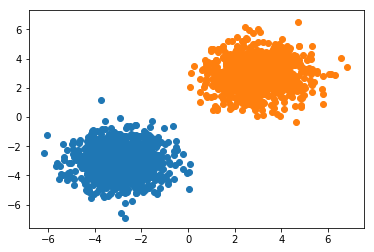

In [49]:
# GENERATE THE DATA

size = 1000
ball_0 = multivariate_normal(mean=[-3,-3], cov=np.eye(2), size=size)
ball_1 = multivariate_normal(mean=[3,3], cov=np.eye(2), size=size)

plt.scatter(ball_0[:,0], ball_0[:,1])
plt.scatter(ball_1[:,0], ball_1[:,1])
plt.show()


# 

In [50]:
def label_to_one_hot(labels):
    enc = OneHotEncoder(categories='auto', sparse=False)
    enc.fit(labels)
    return enc.transform(labels)

In [51]:
y_0 = [0.0] * size 
y_1 = [1.0] * size
y = np.concatenate([y_0, y_1])[:,np.newaxis]
X = np.concatenate([ball_0, ball_1])
y = label_to_one_hot(y)

data = np.hstack([X,y])
print(data.shape)

# permutate random
np.random.shuffle(data)
X = data[:,0:2]
y = data[:,2:]

(2000, 4)


In [52]:
y.shape

(2000, 2)

In [53]:
X.shape

(2000, 2)

In [54]:
NUM_TRAIN = 1500

x_train = X[0:NUM_TRAIN,:]
x_test = X[NUM_TRAIN:,:]

y_train = y[0:NUM_TRAIN]

y_test = y[NUM_TRAIN:]

In [55]:
x_train.shape

(1500, 2)

In [56]:
x_test.shape

(500, 2)

In [57]:
y_test.shape

(500, 2)

In [58]:
NUM_FP = 4
FP_EPS = 0.1
NUM_CLASSES = 2
NUM_FEATURES = 2

# dx is input distortion, number of dxs is equal to number of unique fingerprints
fp_dx = [np.random.rand(1, NUM_FEATURES) * FP_EPS for i in range(NUM_FP)]

# In paper, dy's are the same for each dx, so dy, and they are distortion to logits
# since logits dimension is NUM_CLASSES and we need NUM_CLASSES dy definitions (one
# dy for each class), dy dimension will be NUM_CLASSESS x NUM_CLASSES

# Details in paper, section 2.3 (choosing dys)
fp_dy = -0.2357*np.ones((NUM_CLASSES, NUM_CLASSES))
for cl in range(NUM_CLASSES):
    fp_dy[cl, cl] = 0.7

print('fp_dx')
print(fp_dx)
print('fp_dy')
print(fp_dy)

fp_dx
[array([[0.02033137, 0.03028948]]), array([[0.08586118, 0.07544403]]), array([[0.08249785, 0.00465539]]), array([[0.03542481, 0.00866537]])]
fp_dy
[[ 0.7    -0.2357]
 [-0.2357  0.7   ]]


In [59]:
# Fingerprint training example/label pairs

x_train_fp = np.zeros((NUM_FP, NUM_TRAIN, NUM_FEATURES), dtype=np.float32)
for i in range(NUM_FP):
    x_train_fp[i] = x_train + fp_dx[i]

y_train_fp = np.zeros((NUM_FP, NUM_TRAIN, NUM_CLASSES), dtype=np.float32)
for i in range(NUM_FP):
    for j in range(NUM_TRAIN):
        y_train_fp[i][j] = fp_dy[np.argwhere(y_train[j] == float(1))[0][0]]

In [60]:
print(y_train[0:5])
print(y_train_fp[0][0:5])

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
[[-0.2357  0.7   ]
 [ 0.7    -0.2357]
 [ 0.7    -0.2357]
 [-0.2357  0.7   ]
 [-0.2357  0.7   ]]


In [62]:
x_tf = tf.placeholder(tf.float32, shape=(None, NUM_FEATURES), name="x")
y_tf = tf.placeholder(tf.float32, shape=(None, NUM_CLASSES), name="y")

fp_shape_tenor = tf.stack([
    tf.constant(NUM_FP),
    tf.shape(x_tf)[0],
    tf.constant(NUM_FEATURES)
])

fp_shape_tenor
x_fp_tf = tf.placeholder(tf.float32, shape=fp_shape_tenor, name="x_fp")
x_fp_tf

TypeError: Error converting shape to a TensorShape: Tensor objects are only iterable when eager execution is enabled. To iterate over this tensor use tf.map_fn..

In [81]:
x_tf = tf.placeholder(tf.float32, shape=(None, NUM_FEATURES), name="x")
y_tf = tf.placeholder(tf.float32, shape=(None, NUM_CLASSES), name="y")

x_fp_tf = tf.placeholder(tf.float32, shape=(NUM_FP, None, NUM_FEATURES), name="x_fp")
y_fp_tf = tf.placeholder(tf.float32, shape=(NUM_FP, None, NUM_CLASSES), name="y_fp")

hidden1 = tf.layers.Dense(units=200, activation=tf.nn.relu, name="hidden1")
hidden2 = tf.layers.Dense(units=200, activation=tf.nn.relu, name="hidden2")
out = tf.layers.Dense(units=NUM_CLASSES, activation=tf.nn.relu)

y_logits = hidden1(x_tf)
y_logits = hidden2(y_logits)
y_logits = out(y_logits)
y_logits_normed = y_logits / (tf.stack([tf.norm(y_logits, axis=1)] * NUM_CLASSES, axis=1) + 0.0001)
y_preds = tf.nn.softmax(y_logits)

y_fp_preds = []
for i in range(NUM_FP):
    cur_x_fp = x_fp_tf[i]
    cur_y_fp = hidden1(cur_x_fp)
    cur_y_fp = hidden2(cur_y_fp)
    cur_y_fp = out(cur_y_fp)
    cur_y_fp = cur_y_fp / (tf.stack([tf.norm(cur_y_fp, axis=1)] * NUM_CLASSES, axis=1) + 0.0001)
    y_fp_preds.append(cur_y_fp)
y_fp_preds = tf.stack(y_fp_preds)

loss_vanilla = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_tf, logits=y_logits)
loss_fp = tf.losses.mean_squared_error(y_fp_preds - tf.stack([y_logits_normed] * 4), y_fp_tf)
loss = loss_vanilla + 1.0 * loss_fp

optimizer = tf.train.AdamOptimizer(0.01)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
for i in range(1000):
    if True:
        _, loss_value = sess.run((train, loss), feed_dict={
          x_tf: x_train, y_tf: y_train, x_fp_tf: x_train_fp, y_fp_tf: y_train_fp
        })
        print(loss_value)
    if False:
        lol = sess.run(y_fp_preds - tf.stack([y_logits_normed] * 4), feed_dict={
              x_tf: x_train, y_tf: y_train, x_fp_tf: x_train_fp, y_fp_tf: y_train_fp
            })
        print(lol)

[1.0296725 1.112787  1.1113985 ... 1.1439226 1.0133296 1.0217359]
[0.5924156  0.5164542  0.4833778  ... 0.4202724  0.5033759  0.44597483]
[0.38377005 0.2992553  0.2956632  ... 0.28185707 0.31410408 0.29334557]
[0.3115734  0.27573475 0.27536255 ... 0.2733864  0.28014234 0.27527064]
[0.2865065  0.27315333 0.27310804 ... 0.27282032 0.27423927 0.27312306]
[0.2778834  0.27282807 0.27282044 ... 0.27277502 0.27308717 0.27282533]
[0.27478814 0.27278018 0.27277875 ... 0.27277076 0.27284503 0.27277994]
[0.27361023 0.27277207 0.27277184 ... 0.2727704  0.272789   0.27277207]
[0.2731387  0.27277064 0.27277064 ... 0.2727703  0.2727753  0.27277064]
[0.27293968 0.2727704  0.2727704  ... 0.2727703  0.27277172 0.2727704 ]
[0.2728517  0.2727703  0.2727703  ... 0.2727703  0.27277076 0.2727703 ]
[0.27281117 0.2727703  0.2727703  ... 0.2727703  0.2727704  0.2727703 ]
[0.27279174 0.2727703  0.2727703  ... 0.2727703  0.2727703  0.2727703 ]
[0.27278197 0.2727703  0.2727703  ... 0.2727703  0.2727703  0.2727703 

[0.2727703 0.2727703 0.2727703 ... 0.2727703 0.2727703 0.2727703]
[0.2727703 0.2727703 0.2727703 ... 0.2727703 0.2727703 0.2727703]
[0.2727703 0.2727703 0.2727703 ... 0.2727703 0.2727703 0.2727703]
[0.2727703 0.2727703 0.2727703 ... 0.2727703 0.2727703 0.2727703]
[0.2727703 0.2727703 0.2727703 ... 0.2727703 0.2727703 0.2727703]
[0.2727703 0.2727703 0.2727703 ... 0.2727703 0.2727703 0.2727703]
[0.2727703 0.2727703 0.2727703 ... 0.2727703 0.2727703 0.2727703]
[0.2727703 0.2727703 0.2727703 ... 0.2727703 0.2727703 0.2727703]
[0.2727703 0.2727703 0.2727703 ... 0.2727703 0.2727703 0.2727703]
[0.2727703 0.2727703 0.2727703 ... 0.2727703 0.2727703 0.2727703]
[0.2727703 0.2727703 0.2727703 ... 0.2727703 0.2727703 0.2727703]
[0.2727703 0.2727703 0.2727703 ... 0.2727703 0.2727703 0.2727703]
[0.2727703 0.2727703 0.2727703 ... 0.2727703 0.2727703 0.2727703]
[0.2727703 0.2727703 0.2727703 ... 0.2727703 0.2727703 0.2727703]
[0.2727703 0.2727703 0.2727703 ... 0.2727703 0.2727703 0.2727703]
[0.2727703

KeyboardInterrupt: 

In [20]:
final_preds = sess.run(y_pred, feed_dict={x_tf: x_test})
final_preds = final_preds.squeeze(axis=1)
final_preds = final_preds <= 0.5


In [21]:
sns.scatterplot(x=x_test[:,0], y=x_test[:,1], hue=final_preds)
plt.show()

NameError: name 'sns' is not defined

In [3]:
def frange(x, y, jump):
    while x < y:
        yield x
        x += jump

In [4]:
def generate_grid(minX, minY, maxX, maxY, delta):
    pts = []
    for x in frange(minX, maxX, delta):
        for y in frange(minY, maxY, delta):
            pts.append([x, y])
    return np.array(pts)

In [8]:
grid = generate_grid(-5, -5, 5, 5, 0.1)

In [9]:
grid.shape

(10201, 2)